<a href="https://colab.research.google.com/github/Bhavay192/Bitcoin-Price-Prediction/blob/main/Bitcoin_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Importing Libraries*

In [1]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, GRU
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn import model_selection
from sklearn.svm import SVR
from statsmodels.tsa.arima_model import ARIMA 
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## *Downloading and loading data*

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
hist_df = pd.DataFrame(json.loads(res.content)['Data'])
hist_df = hist_df.set_index('time')
hist_df.index = pd.to_datetime(hist_df.index, unit='s')
target_col = 'close'
hist = hist_df.drop(labels = ['conversionSymbol','conversionType'], axis=1)

In [5]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-08-04,39961.11,37526.24,38189.30,34035.77,1.318984e+09,39738.56
2021-08-05,41409.14,37330.04,39738.56,59748.14,2.357832e+09,40888.18
2021-08-06,43363.62,39895.05,40888.18,48254.57,2.009168e+09,42852.18
2021-08-07,44731.51,42473.57,42852.18,50446.88,2.199730e+09,44617.96
2021-08-08,45310.33,43300.59,44617.96,39433.62,1.745879e+09,43827.75


## *Splitting data*

In [6]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(hist, test_size=0.2)

In [8]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

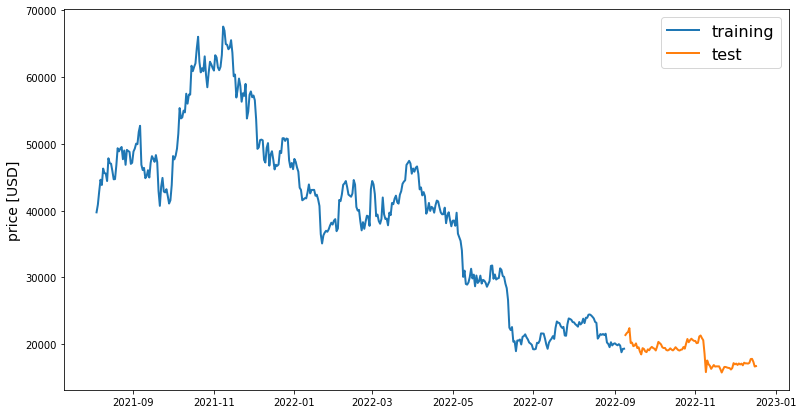

In [9]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

## *Preparing data*

In [10]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [11]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [12]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

## *Models*

In [13]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]), go_backwards=True))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [14]:
def build_gru_model(input_data, output_size, neurons=100, activ_func='linear',
                    dropout=0.2, loss='mse', optimizer='adam'):
  model = Sequential()
  model.add(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
  model.add(Dropout(dropout))
  model.add(Dense(neurons, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))

  model.compile(loss=loss, optimizer=optimizer)
  return model

In [15]:
def build_svm_model(C, kernel, gamma):
  svm_model = SVR(C = C, kernel = kernel, gamma = gamma)
  return svm_model

In [20]:
def ArimaForecasting(actual, p, d, q):
  model = ARIMA(actual, order=(p,d,q))
  result = model.fit(disp=0)
  prediction = result.forecast()[0]
  return prediction

## *Training*

In [16]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
gru_neurons = 120
epochs = 33
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [17]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model_gru = build_gru_model(
    X_train, output_size=1, neurons=gru_neurons, dropout=dropout, loss=loss, optimizer=optimizer)


history_gru = model_gru.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True
)

In [ ]:
model_lstm = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model_lstm.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

## *Evaluation*

In [ ]:
variable = hist['high']
predicted = ArimaForecasting(variable, 1, 1, 0)
print(predicted)

In [ ]:
targets = test[target_col][window_len:]
preds_lstm = model_lstm.predict(X_test).squeeze()
mean_absolute_error(preds_lstm, y_test)

In [ ]:
targets = test[target_col][window_len:]
preds_gru = model_gru.predict(X_test).squeeze()
mean_absolute_error(preds_gru, y_test)

## *Plotting Results*

In [ ]:
preds = test[target_col].values[:-window_len] * (preds_lstm + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [ ]:
preds = test[target_col].values[:-window_len] * (preds_gru + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)